In [1]:
import os

import matplotlib.pyplot as plt
import sinter

from qecdec import RotatedSurfaceCode_Memory
from qecdec import SlidingWindow_Decoder
from qecdec.sinter_wrapper import SinterDecoderWrapper

In [2]:
total_rounds = 50
commit_size = 1
const_window_size = 3


def generate_sinter_tasks_and_custom_decoders():
    tasks: list[sinter.Task] = []
    custom_decoders: dict[str, sinter.Decoder] = {}
    for d in [5, 7, 9, 11]:
        for p in [0.01, 0.02, 0.03, 0.04, 0.05]:
            # Setup the experiment.
            expmt = RotatedSurfaceCode_Memory(
                d=d,
                rounds=total_rounds,
                basis='Z',
                data_qubit_error_rate=p,
                meas_error_rate=p,
            )

            sw_d_window_size = SlidingWindow_Decoder.from_pcm_prior(
                expmt.chkmat,
                expmt.prior,
                detectors_per_layer=expmt.num_detectors_per_layer,
                window_size=d,
                commit_size=commit_size
            )
            sw_d_window_size.configure_inner_decoders('MWPM')
            custom_decoder_id = f"custom_decoder_{len(custom_decoders)}"
            custom_decoders[custom_decoder_id] = SinterDecoderWrapper(sw_d_window_size, expmt.obsmat)
            tasks.append(sinter.Task(
                circuit=expmt.circuit,
                detector_error_model=expmt.dem,
                decoder=custom_decoder_id,
                json_metadata={'d': d, 'p': p, 'window_size': d, 'group': 'd_window_size'},
            ))

            sw_const_window_size = SlidingWindow_Decoder.from_pcm_prior(
                expmt.chkmat,
                expmt.prior,
                detectors_per_layer=expmt.num_detectors_per_layer,
                window_size=const_window_size,
                commit_size=commit_size
            )
            sw_const_window_size.configure_inner_decoders('MWPM')
            custom_decoder_id = f"custom_decoder_{len(custom_decoders)}"
            custom_decoders[custom_decoder_id] = SinterDecoderWrapper(sw_const_window_size, expmt.obsmat)
            tasks.append(sinter.Task(
                circuit=expmt.circuit,
                detector_error_model=expmt.dem,
                decoder=custom_decoder_id,
                json_metadata={'d': d, 'p': p, 'window_size': const_window_size, 'group': 'const_window_size'},
            ))

    return tasks, custom_decoders


tasks, custom_decoders = generate_sinter_tasks_and_custom_decoders()

In [3]:
sinter_stats = sinter.collect(
    num_workers=os.cpu_count() - 1,
    max_shots=10_000_000,
    max_errors=100,
    tasks=tasks,
    custom_decoders=custom_decoders,
    print_progress=True,
)

Starting 7 workers...
40 tasks left:
  workers           decoder eta shots_left errors_left json_metadata                                    
        1  custom_decoder_0   ?   10000000         100 d=5,p=0.01,window_size=5,group=d_window_size     
        1  custom_decoder_1   ?   10000000         100 d=5,p=0.01,window_size=3,group=const_window_size 
        1  custom_decoder_2   ?   10000000         100 d=5,p=0.02,window_size=5,group=d_window_size     
        1  custom_decoder_3 <1m    9999727          57 d=5,p=0.02,window_size=3,group=const_window_size 
        1  custom_decoder_4   ?   10000000         100 d=5,p=0.03,window_size=5,group=d_window_size     
        1  custom_decoder_5   ?   10000000         100 d=5,p=0.03,window_size=3,group=const_window_size 
        1  custom_decoder_6   ?   10000000         100 d=5,p=0.04,window_size=5,group=d_window_size     
        0  custom_decoder_7 ?·∞   10000000         100 d=5,p=0.04,window_size=3,group=const_window_size 
        0  custom_

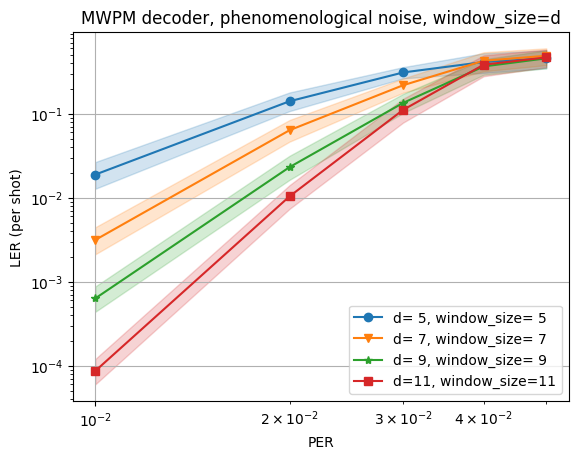

In [4]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=sinter_stats,
    group_func=lambda stat: f"d={stat.json_metadata['d']:2d}, window_size={stat.json_metadata['window_size']:2d}",
    filter_func=lambda stat: stat.json_metadata['group'] == 'd_window_size',
    x_func=lambda stat: stat.json_metadata['p'],
)
ax.loglog()
ax.grid()
ax.set_ylabel('LER (per shot)')
ax.set_xlabel('PER')
ax.set_title('MWPM decoder, phenomenological noise, window_size=d')
ax.legend()

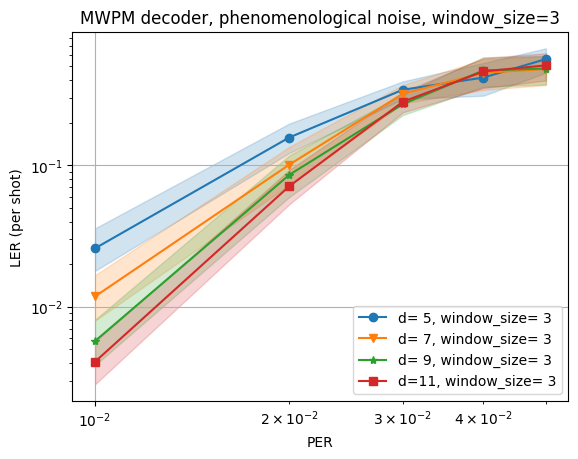

In [5]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=sinter_stats,
    group_func=lambda stat: f"d={stat.json_metadata['d']:2d}, window_size={stat.json_metadata['window_size']:2d}",
    filter_func=lambda stat: stat.json_metadata['group'] == 'const_window_size',
    x_func=lambda stat: stat.json_metadata['p'],
)
ax.loglog()
ax.grid()
ax.set_ylabel('LER (per shot)')
ax.set_xlabel('PER')
ax.set_title(f'MWPM decoder, phenomenological noise, window_size={const_window_size}')
ax.legend()

In [8]:


def generate_sinter_tasks_and_custom_decoders():
    tasks: list[sinter.Task] = []
    custom_decoders: dict[str, sinter.Decoder] = {}
    d = 9
    p = 0.01
    total_rounds = 50
    commit_size = 1

    # Setup the experiment.
    expmt = RotatedSurfaceCode_Memory(
        d=d,
        rounds=total_rounds,
        basis='Z',
        data_qubit_error_rate=p,
        meas_error_rate=p,
    )

    for window_size in range(3, total_rounds + 1):
        sw = SlidingWindow_Decoder.from_pcm_prior(
            expmt.chkmat,
            expmt.prior,
            detectors_per_layer=expmt.num_detectors_per_layer,
            window_size=window_size,
            commit_size=commit_size
        )
        sw.configure_inner_decoders('MWPM')
        custom_decoder_id = f"custom_decoder_{len(custom_decoders)}"
        custom_decoders[custom_decoder_id] = SinterDecoderWrapper(sw, expmt.obsmat)
        tasks.append(sinter.Task(
            circuit=expmt.circuit,
            detector_error_model=expmt.dem,
            decoder=custom_decoder_id,
            json_metadata={'d': d, 'p': p, 'window_size': window_size},
        ))

    return tasks, custom_decoders


tasks, custom_decoders = generate_sinter_tasks_and_custom_decoders()

In [9]:
sinter_stats = sinter.collect(
    num_workers=os.cpu_count() - 1,
    max_shots=10_000_000,
    max_errors=100,
    tasks=tasks,
    custom_decoders=custom_decoders,
    print_progress=True,
)

Starting 7 workers...
48 tasks left:
  workers           decoder eta shots_left errors_left json_metadata            
        1  custom_decoder_0 97m    9999983         100 d=9,p=0.01,window_size=3 
        1  custom_decoder_1   ?   10000000         100 d=9,p=0.01,window_size=4 
        1  custom_decoder_2   ?   10000000         100 d=9,p=0.01,window_size=5 
        1  custom_decoder_3   ?   10000000         100 d=9,p=0.01,window_size=6 
        1  custom_decoder_4   ?   10000000         100 d=9,p=0.01,window_size=7 
        1  custom_decoder_5   ?   10000000         100 d=9,p=0.01,window_size=8 
        1  custom_decoder_6   ?   10000000         100 d=9,p=0.01,window_size=9 
        0  custom_decoder_7 ?·∞   10000000         100 d=9,p=0.01,window_size=10
        0  custom_decoder_8 ?·∞   10000000         100 d=9,p=0.01,window_size=11
        0  custom_decoder_9 ?·∞   10000000         100 d=9,p=0.01,window_size=12
        0 custom_decoder_10 ?·∞   10000000         100 d=9,p=0.01,window

Text(0.5, 1.0, 'MWPM decoder, phenomenological noise, total_rounds=50, d=9, p=0.01')

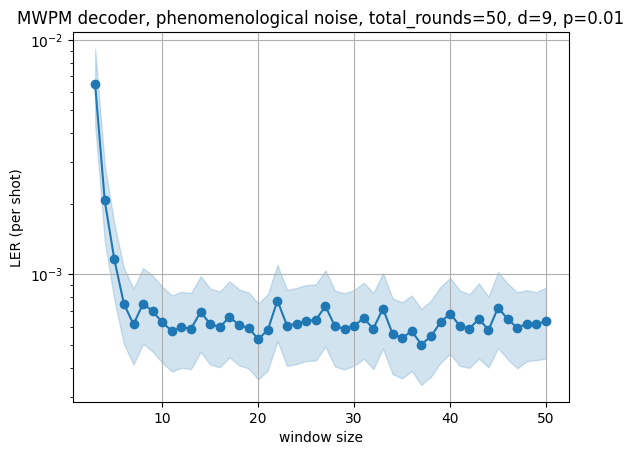

In [13]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=sinter_stats,
    x_func=lambda stat: stat.json_metadata['window_size'],
)
ax.set_yscale('log')
ax.grid()
ax.set_ylabel('LER (per shot)')
ax.set_xlabel('window size')
ax.set_title(f'MWPM decoder, phenomenological noise, total_rounds=50, d=9, p=0.01')